In [1]:
%matplotlib notebook
import numpy as np
import cupy as qp
import operator as op
import time
import matplotlib as mpl
import pandas as pd
from pandas import HDFStore, DataFrame
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive, Button
from IPython.display import display, HTML
import netCDF4 as nc

xp = np

In [2]:
# display functions

def disp3d(fig, aa, lines=(35,35)): # 3d wirefram plot
    # interpert inputs
    aa = qp.asnumpy(aa)
    
#     xlim = box[0]
#     ylim = box[1]
#     zlim = box[2]
#     if (xlim==None):
#         xlim = (0, aa[0].shape[0])
#     if (ylim==None): ylim = (0, aa[0].shape[1])
#     if (zlim==None):
#         ran = np.max(aa[0])-np.min(aa[0])
#         zlim = (np.min(aa[0])-ran, np.max(aa[0])+ran)
#         zlim = (-2, 2)
    
    #'wires' of the wireframe plot
    x = np.linspace(0, aa[0].shape[0]-1, lines[0], dtype=int)
    y = np.linspace(0, aa[0].shape[1]-1, lines[1], dtype=int)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    
    #display it
#     fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
#     for a in aa:
    A = aa#[xx,yy]
    ax.plot_wireframe(xx, yy, A)
    
    return ax



# def genframes(a, frames=120):#np.arange(120, dtype=int)):
#     arts = np.array([])#np.empty((frames.shape[0],))
# #     assert frames.dtype==int, "frames must be a numpy array of integers"
# #     frames = np.asarray(frames, dtype=int)
#     mm = np.max([-np.min(a), np.max(a)])/2
#     ds = a[np.linspace(0, a.shape[0]-1, frames, dtype=int)]
#     for d in ds:
# #         d = np.asarray(a[frame], dtype=np.float32) # data
#         im = plt.imshow(d, animated=True, vmin=-mm, vmax=mm, cmap='seismic')
#         arts = np.append(arts, im)
#     return f

# def motioncon(fig, f): # animated height plot, takes in list of 2d height arrays
    #prepare figure/display
    
#     z = qp.asnumpy(f[0])
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     mm = np.max([-np.min(f), np.max(f)])/2
#     im = ax.imshow(z, vmin=-mm, vmax=mm,cmap='seismic')
#     cb = fig.colorbar(im)
#     tx = ax.set_title(title)
#     plt.xticks(np.linspace(0, z.shape[0], xlabels.shape[0]), xlabels)
#     plt.yticks(np.linspace(0, z.shape[1], ylabels.shape[0]), ylabels)
    
#     def animate(i): # returns i'th element (height array) in f
#         im.set_data(qp.asnumpy(f[i]))
#         plt.contour(h, levels=1, cmap='gray')
    
    #display it
#     anim = animation.ArtistAnimation(fig, f)
#     return anim

def vect(u, v, arws=(10, 10), arwsz=100): # vector /motion plot
    #interpert inputs
    u = qp.asnumpy(u)
    v = qp.asnumpy(v)
#     if (xlim=='default'): xlim = (0, u.shape[0])
#     if (ylim=='default'): ylim = (0, v.shape[1])
    arws = (int(arws[0]), int(arws[1]))
    
    # set up
    x = np.linspace(0, u.shape[0]-1, arws[0], dtype=int)
    y = np.linspace(0, v.shape[1]-1, arws[1], dtype=int)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    uu = u[x,y]
    vv = v[x,y]
    m = np.hypot(uu, vv)
    
    #displat it
    q = plt.quiver(xx, yy, uu, vv, m, scale = 1/arwsz)
#     return ax
#     ax.set_xlim(xlim)
#     ax.set_ylim(ylim)
#     plt.title(title)
#     plt.show()

In [3]:
# useful math functions
def d_dx(a, dx):
    ddx = ( a[:-1] - a[1:] )*(np.float32(-1)/dx) 
    return ddx
def d_dy(a, dy):
    ddy = ( a[:,:-1] - a[:,1:] )*(np.float32(-1)/dy)
    return ddy
def div(u, v, dx, dy):
    div = d_dx(u, dx) + d_dy(v, dy)
    return div

# for generating simple environments or initial conditions
# def hydrodynamic
def planegauss(shape, win=((-2, 2), (-2, 2))):
   # h=np.empty(shape, dtype=np.float32)
    npx = np.linspace( win[0][0], win[0][1], shape[0] )
    npy = np.linspace( win[1][0],win[1][1], shape[1] )
    npxx, npyy = np.meshgrid(npx, npy, indexing='ij')
    h = np.exp( -np.e * ( npxx*npxx + npyy*npyy ) )
    return (h)
def lingauss(shape, w = 1/2, ax = 0, win = (-2, 2)):
   # h=np.empty(shape, dtype=np.float32)
    npx = np.linspace( win[0], win[1], shape[0] )
    npy = np.linspace( win[0], win[1], shape[1] )
    npxx, npyy = np.meshgrid(npy, npx)
    xy = (npyy, npxx)[ax]
    h = np.exp( -np.e * ( xy*xy ) / (w*w) )
    return (h)

In [4]:
# physics constants
class p():
    g = np.float32(9.81) # gravity

class State(): # state
    def __init__(self, h, n, u, v, dx, dy, lat, lon):
        
        self.dx = dx
        self.dy = dy
        self.lat = lat
        self.lon = lon
#         self.lats, self.lons = np.meshgrid(self.lat, self.lon)
#         self.lat, self.lon = np.meshgrid(self.lat, self.lon) # lattitude/longitude chunk simulation area stretches over
        self.h = h
    
        self.maxws = np.sqrt(np.max(self.h)*p.g) # maximum wave speed
        
        self.n = np.asarray(n, dtype=np.float32) # surface height (eta)
        self.u = np.asarray(u, dtype=np.float32) # x vel array
        self.v = np.asarray(v, dtype=np.float32) # y vel array
        
        #make sure h is the same shap as n (eta)
        assert (np.isscalar(h) or self.h.shape == self.n.shape), "H and N must have the same shape, or H must be a scalar" # 'or' is short circuit
        
#         self.calcDt()
        self.dt = np.min((np.min(self.dx), np.min(self.dy)))/(5*self.maxws)
        
        self.coriolis = np.float32(((2*2*np.pi*np.sin(self.lat*np.pi/180))/(24*3600))[:,np.newaxis]) # rotation speed of the earth dtheta/dt
        """ derivation of coriolis force
        U = R*cos(phi)*O
        ui = U+ur
        ur = ui-U
        dU/dphi = -R*sin(phi)*O
        phi = y/R
        dphi/dt = v/R
        dU/dt = v*(-sin(phi)*O)
        dur/dt = dui/dt - dU/dt = v*O*sin(phi)
        dur/dt = v*O*sin(phi)"""
        self.movetodevice()
    def movetodevice(self):
        self.lat = xp.asarray(self.lat)
        self.lon = xp.asarray(self.lon)
        self.h = xp.asarray(self.h)
        self.n = xp.asarray(self.n)
        self.u = xp.asarray(self.u)
        self.v = xp.asarray(self.v)
        self.coriolis = xp.asarray(self.coriolis)
#     def calcDt(self, fudge = 5): #calculate optimal value of dt for the height and dx values
#         dx = np.min(self.dx)
#         dy = np.min(self.dy)
#         self.dt = np.min((dx, dy))/(fudge*self.maxws)
props = op.itemgetter('h', 'n', 'u', 'v', 'dx', 'dy', 'lat', 'lon') # for grrabbing the elements of a state
# def newstate(state):
#     return State(*(props(vars(state))))


# physics shallow water framework

## Class of objects to hold current state of an ocean grid 

Equations of motion
$$
\begin{align}
\frac{\partial \eta}{\partial t} & =
    -\frac{\partial  }{\partial x} \bigl( \left( \eta + h\right)u \bigr) 
    - \frac{\partial  }{\partial y}  \bigl( \left( \eta + h\right)v \bigr)\\  
\\
\frac{\partial u}{\partial t} & = Coriolis + Advection + Gravity + Attenuation\\
 & = +fv +\bigl( \kappa\nabla^{2}u - (u,v)\cdot\vec\nabla u \bigr)  
    - g\frac{\partial \eta}{\partial x} - \frac{1}{\rho (h + \eta)} \mu u \sqrt{u^{2} + v^{2}}\\  
& = +fv +\bigl( \kappa\frac{\partial^{2} u}{\partial x^{2}}
           +\kappa\frac{\partial^{2} u}{\partial y^{2}}
           -u\frac{\partial u}{\partial x} - v\frac{\partial u}{\partial y}\bigr) 
           - g\frac{\partial \eta}{\partial x}
            - \frac{1}{\rho (h + \eta)} \mu u \sqrt{u^{2} + v^{2}}\\
\\
\frac{\partial v}{\partial t} & = -fu 
   + \bigl( \kappa\nabla^{2}v - (u,v)\cdot\vec\nabla v \bigr) 
    - g\frac{\partial \eta}{\partial y}
    - \frac{1}{\rho (h + \eta)} \mu v \sqrt{u^{2} + v^{2}}\\   
& = -fu+\bigl( \kappa\frac{\partial^{2} v}{\partial x^{2}}
           +\kappa\frac{\partial^{2} v}{\partial y^{2}}
           -u\frac{\partial v}{\partial x} - v\frac{\partial v}{\partial y}\bigr) 
           - g\frac{\partial \eta}{\partial y}
           - \frac{1}{\rho (h + \eta)} \mu v \sqrt{u^{2} + v^{2}}\\           
\end{align}
$$

Where 
- *_h_* calm ocean depth (positive number) at any point. Presumed constant in time
- $\eta$ is the wave height above the calm ocean height
- *_u_* is the mean water column velocity in the _x_ (east) direction
- *v* is the mean water column velocity in the _y_ (north) direction

and the physcial constant parameters are:
- *g* gravitational constant
- *f* is the lattidude dependent coriolis coefficient: $2\omega \sin(latitude)$
- $\kappa$ is the viscous damping coefficient across the grid cell boundaries
- $\mu$ is the friction coeffecient


In [5]:
zero = np.float32(0)
p5 = np.float32(0.5)
one = np.float32(1)
two = np.float32(2)

def dndt(h, n, u, v, dx, dy) : # for individual vars
# def dndt(state):
    """change in n per timestep, by diff. equations"""
#     h, n, u, v, dx, dy = [qp.asnumpy(state.__dict__[k]) for k in ('h', 'n', 'u', 'v', 'dx', 'dy')]
    hx = xp.empty(u.shape, dtype=n.dtype) # to be x (u) momentum array
    hy = xp.empty(v.shape, dtype=n.dtype)
    
    depth = h+n
    hx[1:-1] = (depth[1:] + depth[:-1])*p5 # average
    hx[0] = zero#depth[0]#*2-depth[1] # normal flow boundaries/borders
    hx[-1] = zero#depth[-1]#*2-depth[-2] # the water exiting the water on the edge is n+h
    
    hy[:,1:-1] = (depth[:,1:] + depth[:,:-1])*p5
    hy[:,0] = zero#depth[:,0]#*2-depth[:,1]
    hy[:,-1] = zero#depth[:,-1]#*2-depth[:,-2]
    
    hx *= u # height/mass->momentum of water column.
    hy *= v
#     dndt = d_dx(hx, -dx)+d_dy(hy, -dy)#(div(hx, hy, -dx, -dy))
    return ( d_dx(hx, -dx)+d_dy(hy, -dy) )
 # change in x vel. (u) per timestep
    
# countx=0
    
def dudt(h, n, f, u, v, dx, dy, nu, mu=0.3) : # for individual vars
    mu = np.float32(mu)
# def dudt(state):
#     f, n, u, v, dx, dy = [qp.asnumpy(state.__dict__[k]) for k in ('coriolis', 'n', 'u', 'v', 'dx', 'dy')]
    dudt = xp.empty(u.shape, dtype=u.dtype) # x accel array
    grav = d_dx(n, -dx/p.g)
    dudt[1:-1] = grav
#     dudt[0] = grav[0]*2-grav[1] # assume outside map wave continues with constant slope
#     dudt[-1] = grav[-1]*2-grav[-2]
    
    
    # coriolis force
    vn = (v[:,1:]+v[:,:-1])*p5 # n shaped v
    
    fn = f#(f[:,1:]+f[:,:-1])*0.5 # n shaped f
    fvn = (fn*vn) # product of coriolis and y vel.
    dudt[1:-1] += (fvn[1:]+fvn[:-1])*p5 # coriolis force
    dudt[0] += fvn[0]
    dudt[-1] += fvn[-1]
    
    
    # advection
    
    # advection in x direction
    dudx = d_dx(u, dx)
    
    dudt[1:-1] -= u[1:-1]*(dudx[1:] + dudx[:-1])*p5 # advection
#     dudt[0] -= u[0]*dudx[0]
#     dudt[-1] -= u[-1]*dudx[-1]
    
    # advection in y direction
    duy = xp.empty(u.shape, dtype=u.dtype)
    dudy = d_dy(u, dy)
    duy[:,1:-1] = ( dudy[:,1:] + dudy[:,:-1] ) * p5
    duy[:,0] = dudy[:,0]
    duy[:,-1] = dudy[:, -1]
    dudt[1:-1] -= (vn[1:]+vn[:-1])*p5*duy[1:-1] # advection
#     dudt[0] -= vn[0]*duy[0]
#     dudt[-1] -= vn[-1]*duy[-1] # closest to applicable position
    
    
    #attenuation
    una = (u[1:]+u[:-1]) * p5
    vna = (v[:,1:]+v[:,:-1])*p5
    attenu = 1/(h+n) * mu * una * np.sqrt(una*una + vna*vna) # attenuation
    dudt[1:-1] -= (attenu[1:] + attenu[:-1])*p5
    
    # viscous term
#     nu = np.float32(1000/dx)

#     ddux = d_dx(dudx, dx)
#     dduy = xp.empty(u.shape, dtype=u.dtype)
#     ddudy = d_dy(duy, dy)
#     dduy[:,1:-1] = ( ddudy[:,1:] + ddudy[:,:-1] ) * p5
#     dduy[:,0] = ddudy[:,0]
#     dduy[:,-1] = ddudy[:, -1]
#     dudt[1:-1] -= nu*(ddux+dduy[1:-1])
    
#     dudt[0] += nu*ddux[0]*dduy[0]
#     dudt[-1] += nu*ddux[-1]*dduy[-1]
    
    dudt[0] = zero
    dudt[-1] = zero # reflective boundaries
    dudt[:,0] = zero
    dudt[:,-1] = zero # reflective boundaries
    return ( dudt )

def dvdt(h, n, f, u, v, dx, dy, nu, mu=0.3) :
    mu = np.float32(mu)
# def dvdt(state):
#     f, n, u, v, dx, dy = [qp.asnumpy(state.__dict__[k]) for k in ('coriolis', 'n', 'u', 'v', 'dx', 'dy')]
    #
    dvdt = xp.empty(v.shape, dtype=v.dtype) # x accel array
    grav = d_dy(n, -dy/p.g)
    dvdt[:,1:-1] = grav
#     dvdt[:,0] = grav[:,0]*two-grav[:,1] # assume outside map wave continues with constant slope
#     dvdt[:,-1] = grav[:,-1]*two-grav[:,-2]
    
    
    # coriolis force
    un = (u[1:]+u[:-1])*p5 # n-shaped u
    
    fun = (f*un) # product of coriolis and x vel.
    dvdt[:,1:-1] += (fun[:,1:]+fun[:,:-1])*0.5 # coriolis force
#     dvdt[:,0] += fun[:,0]
#     dvdt[:,-1] += fun[:,-1]
    
    
    
    # advection
    
    # advection in y direction
    dvdy = d_dy(v, dy)
    
    dvdt[:,1:-1] -= v[:,1:-1]*(dvdy[:,1:] + dvdy[:,:-1])*p5 # advection
#     dvdt[:,0] -= v[:,0]*dvdy[:,0]
#     dvdt[:,-1] -= v[:,-1]*dvdy[:,-1]
    
    # advection in x direction
    dvx = xp.empty(v.shape, dtype=v.dtype)
    dvdx = d_dx(v, dx)
    dvx[1:-1] = ( dvdx[1:] + dvdx[:-1] ) * p5
    dvx[0] = dvdx[0]
    dvx[-1] = dvdx[-1]
    dvdt[:,1:-1] -= (un[:,1:]+un[:,:-1])*p5*dvx[:,1:-1] # advection
#     dvdt[:,0] -= un[:,0]*dvx[:,0]
#     dvdt[:,-1] -= un[:,-1]*dvx[:,-1] # closest to applicable position
    
    
    una = (u[1:]+u[:-1]) * p5
    vna = (v[:,1:]+v[:,:-1])*p5
    attenu = 1/(h+n) * mu * vna * np.sqrt(una*una + vna*vna) # attenuation
    dvdt[:,1:-1] -= (attenu[:,1:] + attenu[:,:-1])*p5
    
    
    # viscous term
#     nu = np.float32(dy/1000) # nu given as argument

#     ddvy = d_dy(dvdy, dy)
#     ddvx = xp.empty(v.shape, dtype=v.dtype)
#     ddvdx = d_dx(dvx, dx)
#     ddvx[1:-1] = ( ddvdx[1:] + ddvdx[:-1] ) * p5
#     ddvx[0] = ddvdx[0]
#     ddvx[-1] = ddvdx[-1]
#     dvdt[:,1:-1] -= nu*(ddvy+ddvx[:,1:-1])

#     dvdt[:,0] += nu*ddvx[:,0]*ddvy[:,0]
#     dvdt[:,-1] += nu*ddvx[:,-1]*ddvy[:,-1]
    
    dvdt[0] = zero
    dvdt[-1] = zero # reflective boundaries
    dvdt[:,0] = zero
    dvdt[:,-1] = zero # reflective boundaries
    return dvdt

In [6]:
def land(h, u, v, coastx): # how to handle land/above water area
    #boundaries / land
#     coastx = xp.less(h, thresh) # start a little farther than the coast so H+n is never less than zero
    (u[1:])[coastx] = zero
    (u[:-1])[coastx] = zero # set vel. on either side of land to zero, makes reflective
    (v[:,1:])[coastx] = zero
    (v[:,:-1])[coastx] = zero
    return (u, v)

def border(n, u, v, margwidth=15, alph=0.95):
    alph = np.float32(alph)
    n[0:margwidth] *= alph
    n[-1:-margwidth-1:-1] *= alph
    n[:,0:margwidth] *= alph
    n[:,-1:-margwidth-1:-1] *= alph
    
    u[0:margwidth] *= alph
    u[-1:-margwidth-1:-1] *= alph
    u[:,0:margwidth] *= alph
    u[:,-1:-margwidth-1:-1] *= alph
    
    v[0:margwidth] *= alph
    v[-1:-margwidth-1:-1] *= alph
    v[:,0:margwidth] *= alph
    v[:,-1:-margwidth-1:-1] *= alph
    return n, u, v

In [7]:

def forward(h, n, u, v, f, dt, dx, dy, nu, doland, coastx, beta=0, mu=0.3): # forward euler and forward/backward timestep
    """
        beta = 0 forward euler timestep
        beta = 1 forward-backward timestep
    """
    beta = np.float32(beta)
    mu = np.float32(mu)
    
    n1 = n + ( dndt(h, n, u, v, dx, dy) )*dt
    u1 = u + ( beta*dudt(h, n1, f, u, v, dx, dy, mu) +  (one-beta)*dudt(h, n, f, u, v, dx, dy, mu) )*dt
    v1 = v + ( beta*dvdt(h, n1, f, u, v, dx, dy, mu) +  (one-beta)*dvdt(h, n, f, u, v, dx, dy, mu) )*dt
    
    u1, v1 = doland(h, u1, v1, coastx) # handle any land in the simulation
    n1, u1, v1 = border(n1, u1, v1, 15, 0.95)
    return n1, u1, v1

def fbfeedback(h, n, u, v, f, dt, dx, dy, nu, doland, coastx, beta=1/3, eps=2/3, mu=0.3): # forward backward feedback timestep
    beta = np.float32(beta)
    eps = np.float32(eps)
    mu = np.float32(mu)
    n1g, u1g, v1g = forward(h, n, u, v, f, dt, dx, dy, nu, doland, coastx, beta, mu) # forward-backward first guess
    #feedback on guess
    
    n1 = n + p5*(dndt(h, n1g, u1g, v1g, dx, dy) + dndt(h, n, u, v, dx, dy))*dt
    u1 = u + p5*(eps*dudt(h, n1, f, u, v, dx, dy, nu, mu)+(one-eps)*dudt(h, n1g, f, u1g, v1g, dx, dy, nu, mu)+dudt(h, n, f, u, v, dx, dy, nu, mu))*dt
    v1 = v + p5*(eps*dvdt(h, n1, f, u, v, dx, dy, nu, mu)+(one-eps)*dvdt(h, n1g, f, u1g, v1g, dx, dy, nu, mu)+dvdt(h, n, f, u, v, dx, dy, nu, mu))*dt
    
    u1, v1 = doland(h, u1, v1, coastx) # how to handle land/coast
    n1, u1, v1 = border(n1, u1, v1, 15, 0.95)
    return n1, u1, v1




def timestep(h, n, u, v, f, dt, dx, dy, nu, coastx, mu): return fbfeedback(h, n, u, v, f, dt, dx, dy, nu, land, coastx, mu) # switch which integrator/timestep is in use
# def timestep(state): return fbfeedback(state, land) # which integrator/timestep is in use

#

In [8]:
def simulate(initstate, t, mu=0.3, colormap='seismic'): # gives surface height array of the system after evert dt
    """
        evolve shallow water system from initstate over t seconds
        returns:
            animframes (numpy array of matplotlib imshows) numpy array,
            maxn (the maximum value of n over the duration at each point) numpy array,
            minn (the minimum value of n over the duration at each point) numpy array,
            timemax (the number of seconds until the maximum height at each point) numpy array
    """
    h, n, u, v, f, dx, dy, dt = [qp.asnumpy(initstate.__dict__[k]) for k in ('h', 'n', 'u', 'v', 'coriolis', 'dx', 'dy', 'dt')]#h, state.n, state.u, state.v, state.dx, state.dy, state.dt
    nu = (dx+dy)/1000
    #     state = initstate
    mmax = np.max(np.abs(n))
    landthresh = 1.5*np.max(n) # threshhold for when sea ends and land begins
    itrs = int(np.ceil(t/dt))
    
#     nshdf = HDFStore('etaevolvestorage')
    
    assert (dt >= 0), 'negative dt!' # dont try if timstep is zero or negative
    
    ns = np.memmap('etaevolvedata', dtype='float32', mode='w+', shape=(itrs,)+n.shape)
    #np.zeros((itrs,)+n.shape, dtype=n.dtype)
#     animframes = np.array([(plt.imshow(qp.asnumpy(n), vmin=-mmax, vmax=mmax, cmap=colormap),)])
    maxn = np.zeros(n.shape, dtype=n.dtype) # max height in that area
    minn = np.zeros(n.shape, dtype=n.dtype) # minimum height that was at each point
    timemax = np.zeros(n.shape, dtype=n.dtype) # when the maximum height occured
    
    coastx = xp.less(h, landthresh) # where the reflective condition is enforced on the coast
    try:
        for itr in range(itrs):# iterate for the given number of iterations
            n, u, v = timestep(h, n, u, v, f, dt, dx, dy, nu, coastx, mu) # pushes n, u, v one step into the future
            ns[itr] = n
            
#             nshdf.put(str(itr), DataFrame(n)) # save n value to nshdf with key the iteration number
#             animframes = np.append(animframes, (plt.imshow(qp.asnumpy(n), vmin=-mmax, vmax=mmax, cmap=colormap),))
#             np.save('etaevolvestorage', ns)
            maxn = np.max((n, maxn), axis=0) # record new maxes if they are greater than previous records
            minn = np.min((n, minn), axis=0)
            timemax[np.greater(n, maxn)] = itr*dt
#             if (itr%ff = 0):
        
    except:
        print('timestep #:' + str(itr))
        ns.flush()
#         return animframes, maxn, minn, timemax
        raise Exception('error occured in simulate, printed timestep#')
    ns.flush()
#     nshdf.close()
    print('simulation complete')
    return ns, maxn, minn, timemax # return surface height through time and maximum heights

In [10]:
class wonk():

        dur = 500 # duration of period to calculate speed over
        size = (10, 1000) # grid squares (dx's)
        dx = np.single(100, dtype=np.float32) # meters
        dy = np.single(100, dtype=np.float32)
        lat = np.linspace(0, 0, size[0]) # physical location the simulation is over
        lon = np.linspace(0, 0 , size[1])
        h = np.float32(100)*np.ones(size,dtype=np.float32)
        n = 1*lingauss(size, 1/4, 1) # intial condition single wave in the center
        u = np.zeros((size[0]+1, size[1]+0)) # x vel array
        v = np.zeros((size[0]+0, size[1]+1)) # y vel array
        margin = 0.1 # error margin of test
W=wonk
testStart = State(W.h, W.n, W.u, W.v, W.dx, W.dy, W.lat, W.lon)
simdata = simulate(testStart, W.dur)

simulation complete


# verification

simulation complete


<IPython.core.display.Javascript object>


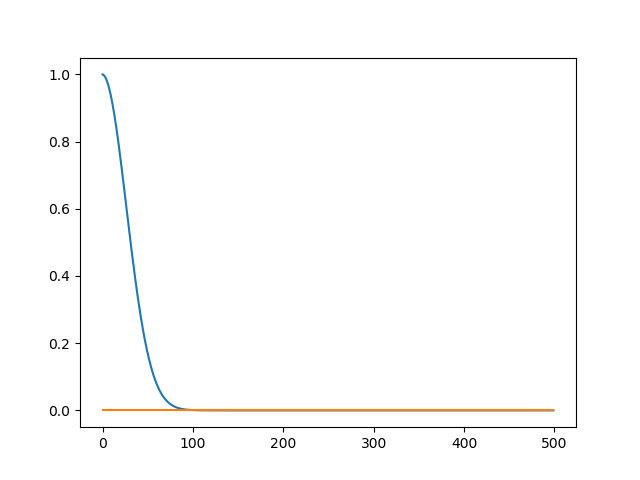

F.

-0.137956382314234 0.1



FAIL: test_wavespeed (__main__.testWaveSpeed)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-11-a746d20cbb98>", line 42, in test_wavespeed
    assert(abs(err) < self.margin) # error margin
AssertionError

----------------------------------------------------------------------
Ran 2 tests in 5.304s

FAILED (failures=1)


In [11]:
#wavespeed and differential tests
import unittest
fooo = []
class testWaveSpeed(unittest.TestCase): # tests if the wave speed is correct
    def setUp(self):
        self.dur = 500 # duration of period to calculate speed over
        self.size = (10, 1000) # grid squares (dx's)
        self.dx = np.single(100, dtype=np.float32) # meters
        self.dy = np.single(100, dtype=np.float32)
        self.lat = np.linspace(0, 0, self.size[0]) # physical location the simulation is over
        self.lon = np.linspace(0, 0 , self.size[1])
        self.h = np.float32(100)
        self.n = 1*lingauss(self.size, 1/4, 1) # intial condition single wave in the center
        self.u = np.zeros((self.size[0]+1, self.size[1]+0)) # x vel array
        self.v = np.zeros((self.size[0]+0, self.size[1]+1)) # y vel array
        self.margin = 0.1 # error margin of test
    def calcWaveSpeed(self, ar1, ar2, Dt): # calculat how fast the wave is propagating out
        midstrip1 = ar1[int(ar1.shape[0]/2),int(ar1.shape[1]/2):]
        midstrip2 = ar2[int(ar1.shape[0]/2),int(ar2.shape[1]/2):]
        peakloc1 = np.argmax(midstrip1)
        peakloc2 = np.argmax(midstrip2)
        plt.figure(1)
        plt.clf()
        plt.plot(midstrip1)
        plt.plot(midstrip2)
        plt.show()
        speed = (peakloc2 - peakloc1)*self.dy/Dt
        return speed
    def calcExactWaveSpeed(self): # approximently how fast the wave should be propagating outwards
        ws = np.sqrt(p.g*np.average(self.h))
        return ws
    def test_wavespeed(self): # test if the expected and calculated wave speeds line up approcimently
        self.testStart = State(self.h, self.n, self.u, self.v, self.dx, self.dy, self.lat, self.lon)
        self.simdata = simulate(self.testStart, self.dur)
#         self.testFrames, self.testmax, self.testmin = self.simdata[:3]
        self.testFrames = self.simdata[0]
        self.testEndN = self.testFrames[-1]
        calcedws = self.calcWaveSpeed( self.testStart.n, self.testEndN, self.dur )
        exactws = self.calcExactWaveSpeed()
        err = (calcedws - exactws)/exactws
        print(err, self.margin)
        assert(abs(err) < self.margin) # error margin
    def tearDown(self):
        del(self.dur)
        del(self.dx)
        del(self.dy)
        del(self.lat)
        del(self.lon)
        del(self.size)
        del(self.h)
        del(self.n)
        del(self.u)
        del(self.v)

class testdifferential(unittest.TestCase): # differental function test (d_dx)
    def setUp(self):
        self.a = np.arange(144) # test input
        self.a = self.a.reshape(12, 12) # make into 2d array
        self.ddthreshold = 1E-16
    def test_ddx(self):
        da = d_dx(self.a, 1)
        diff = np.abs(da[1:-1] - np.mean(da[1:-1]))
        maxdiff = np.max(diff)
        self.assertTrue(np.all(np.abs(da[-1:1] < self.ddthreshold)),"expected zero along borders")
        self.assertTrue(np.all(diff < self.ddthreshold),"Expected constant d_dx less than %f but got %f"%(self.ddthreshold,maxdiff))
    def tearDown(self):
        del(self.a)
        del(self.ddthreshold)

unittest.main(argv=['first-arg-is-ignored'], exit=False)
#You can pass further arguments in the argv list, e.g.
#unittest.main(argv=['ignored', '-v'], exit=False)      
#unittest.main()

In [12]:
simpletestcase = {
    'h': 1000*np.ones((100, 100), dtype=np.float),
    'n': planegauss((100, 100), ((-4, 4),(-4,4))),
    'u': np.zeros((101, 100)),
    'v': np.zeros((100, 101)),
    'dx': 100,
    'dy': 100,
    'lat': np.zeros((100,)),
    'lon': np.zeros((100,))
}
simpleState = State(**simpletestcase)
simpleframes, simpleMax = simulate(simpleState, 200)[0:2]#, simpleMax, simpleMin, simpleAT

# fig = plt.figure(23)
# plt.imshow(simpleframes[50])v

/home/rrs/anaconda3/envs/shallowwater/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in add
/home/rrs/anaconda3/envs/shallowwater/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in add


simulation complete


<IPython.core.display.Javascript object>


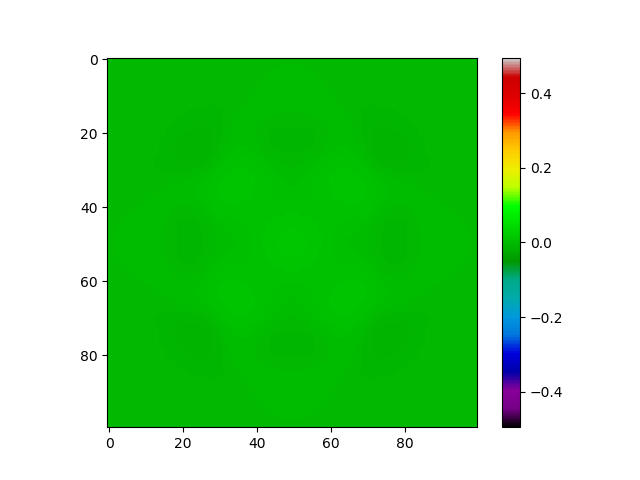

<IPython.core.display.Javascript object>


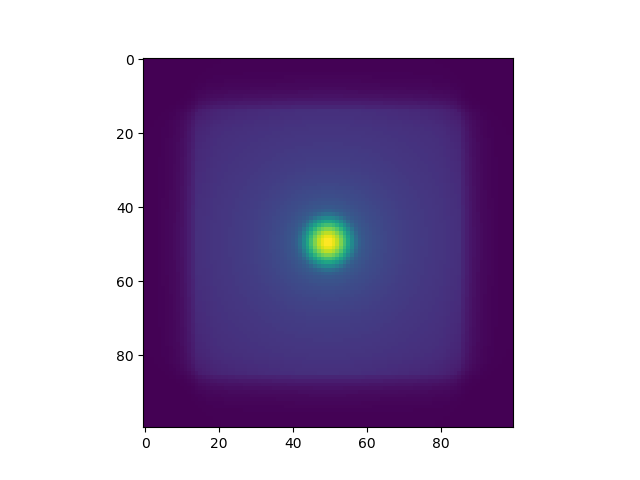

In [15]:
fig = plt.figure(24)
mmax = np.max(np.abs(simpleframes))/2
simpleart = [(plt.imshow(simplef, vmin=-mmax, vmax=mmax, cmap='nipy_spectral'),) for simplef in simpleframes[::5]]
anim = animation.ArtistAnimation(fig, simpleart, interval=50, blit=True, repeat_delay=200)
plt.colorbar()
plt.show()
fig = plt.figure(26)
plt.imshow(simpleMax)

In [17]:
anim.save('../results/simpleplop.mp4')

In [ ]:
friccase = {
    'h': 1000,#*np.ones((100, 100), dtype=np.float),
    'n': planegauss((100, 100)),
    'u': np.zeros((101, 100)),
    'v': np.zeros((100, 101)),
    'dx': 100,
    'dy': 100,
    'lat': np.zeros((100,)),
    'lon': np.zeros((100,))
}
fricState = State(**friccase)
fricframes = simulate(fricState, 100, 100)[0]#, simpleMax, simpleMin, simpleAT
nofricframes = simulate(fricState, 100, 100, 0.0)[0]
# fig = plt.figure(23)
# plt.imshow(simpleframes[50])v

In [ ]:
fig = plt.figure(25)
fricdif = (fricframes-nofricframes)/(np.abs(fricframes)+np.abs(nofricframes)+1E-10)
fricart = [(plt.imshow(fricf, vmin=np.min(fricdif), vmax=np.max(fricdif)),) for fricf in fricdif]
anim = animation.ArtistAnimation(fig, fricart, interval=50, blit=True, repeat_delay=0)
plt.colorbar()
plt.show()
print(np.mean(fricdif))

# indonesian tsunami

In [ ]:

class indone2004():
    event = {
        'lat': 3.316,
        'lon': 95.854
    } # source of the tsunami
    
    dlat = 111000 # latitude degree to meters
    psize = (dlat*30*np.cos(22.5*np.pi/180), dlat*15) # physical size of area
    size = (2500, 1250) # grid squares (dx) # lat, lon

    dx = np.single(psize[0]/size[0], dtype=np.float32) # meters
    dy = np.single(psize[1]/size[1], dtype=np.float32) # meters

    
    bath = nc.Dataset('../data/bathymetry.nc','r')
    
    rxy = (8, 16)
    lat = bath.variables['lat'][:]#[latin]
    lon = bath.variables['lon'][:]
    latr = (np.abs(lat-event['lat']+rxy[1]).argmin(), np.abs(lat-event['lat']-rxy[1]).argmin())
    lonr = (np.abs(lon-event['lon']+rxy[0]).argmin(), np.abs(lon-event['lon']-rxy[0]).argmin())
    latin = np.linspace(latr[0], latr[1], size[0], dtype=int)
    lonin = np.linspace(lonr[0], lonr[1], size[1], dtype=int) # indexes of the bathymetry dataset we need
    lat = bath.variables['lat'][latin]
    lon = bath.variables['lon'][lonin]
    h = np.asarray(-bath.variables['elevation'][latin, lonin], dtype=np.float32)

    n = np.zeros(size)

    evinlat = np.argmin(np.abs(lat - event['lat']))
    evinlon = np.argmin(np.abs(lon - event['lon'])) # the index of the closest value to the correct longitude
    rady = 1+2*(int(25000/dy)//2) # number of indicies across the disturbance is
    radx = 1+2*(int(25000/dx)//2) # modified to be odd, so a point lands on the max of the gaussian
#     evpatch = \

#     evpatch = \
    n[evinlat-rady:evinlat+rady, evinlon-radx:evinlon+radx] = \
    50*planegauss((2*rady, 2*radx))

    u = np.zeros((size[0]+1, size[1]+0))
    v = np.zeros((size[0]+0, size[1]+1))

indonesia = State(*(props(vars(indone2004))))

In [ ]:
seasurface = qp.asnumpy(indonesia.n)#np.empty(qp.asnumpy(indonesia.n).shape)
# seasurface[::-1] = qp.asnumpy(indonesia.n)
bathymetry = -qp.asnumpy(indonesia.h)


plt.figure(116)
plt.title('initial conditions of indonesia simulation')

# plt.subplot(121)
a1 = plt.imshow(seasurface, cmap='seismic', vmin=-np.max(seasurface), vmax=np.max(seasurface))
tt1 = plt.title('initial sea surface height')
cb1 = plt.colorbar()
cb1.set_label('sea surface height (m)')

# plt.subplot(222)
a2 = plt.contour(-bathymetry, cmap='Greys')
tt2 = plt.title('bathymetry')
# cb2 = plt.colorbar()
# cb2.set_label('ocean depth (m)')

# plt.subplot(122)
# # a3 = vect()
# tt3 = plt.title('inital velocity (m/s)')


In [ ]:
indosim = simulate(indonesia, 2500)
indot = indosim[0]
maxindo = indosim[1]
minindo = indosim[2]
tmindo = indosim[3]

masq = np.zeros(qp.asnumpy(indonesia.h).shape, dtype=qp.asnumpy(indonesia.h).dtype)
runuplocs = np.array([(5.251, 95.253), (5.452, 95.242), (5.389, 95.960), (2.575, 96.269), (4.208, 96.040)])
radx = masq.shape[0]//100
rady = masq.shape[1]//100
for runuploc in runuplocs:
    arglat, arglon = np.argmin(np.abs(indonesia.lat-runuploc[0])), np.argmin(np.abs(indonesia.lon-runuploc[1])) # gat the index location of this event
    masq[arglat-radx:arglat+radx, arglon-rady:arglon+rady] = 1 # make a small blip around the locatoin

plt.figure(123)
plt.contour(masq)
plt.show()

In [ ]:
# shallowWater/data/2004indonesiarunups.txt

In [ ]:
indof = np.transpose(indot, (0, 1, 2))
print(indof.shape)
maxt = np.max(indof,axis=(1,2))
print(maxt.shape)
imaxt = np.float32(1.0/maxt)
# plt.figure(888)
# plt.semilogy(maxt)
# plt.show()
norm_indof = indof*imaxt[:,np.newaxis,np.newaxis]

h = qp.asnumpy(indonesia.h)
# ht = np.transpose(h)
ht = h

In [ ]:
fig = plt.figure(122)

# plt.subplot(1, 3, 1)
plt.title('movie')
# f = genframes(norm_indof*0.3, frames=np.linspace(0, norm_indof.shape[0]-1, 300, dtype=int))
indoArts = [(plt.imshow(normindoframe, cmap='seismic', vmin=-np.max(normindoframe), vmax=np.max(normindoframe)),) for normindoframe in norm_indof]
indoAnim = animation.ArtistAnimation(fig, indoArts)
cb = plt.colorbar()
cbtt = cb.set_label('sea surface height (m)')


coast = plt.contour(ht, colors='black', levels=1)#, levels=3)
# locmask = plt.contour(masq, colors='green', levels=2)

In [ ]:
fig = plt.figure(124)
plt.title('maximum')
plt.imshow(maxindo+1, cmap='seismic', norm=mpl.colors.LogNorm())
# plt.colorbar()
plt.contour(ht-20, colors='black', levels=1)

In [ ]:
fig = plt.figure(126)
plt.title('minimum')
plt.imshow(1-minindo, cmap='seismic', norm=mpl.colors.LogNorm())
    # plt.colorbar()
plt.contour(ht-20, colors='black', levels=1)

plt.show()

# comparing indonesia sim to real data

In [ ]:
import pandas as pd

ff = pd.read_csv('~rrs/shallowWater/data/2004indonesiarunups2.txt',sep='\t')
#with open('~rrs/shallowWater/data/2004indonesiarunups.txt','r') as f:
#     txt = f.read()
ff   

In [ ]:
# includes the whole world
allruns = pd.read_csv('~rrs/shallowWater/data/al2004indorunups2.txt', sep='\t')
allruns = allruns.dropna(how='any',subset=['Latitude', 'Longitude', 'TTHr', 'TTMin', 'MaxWaterHeight'])
allruns = allruns.loc[:,['Latitude','Longitude','MaxWaterHeight','DistanceFromSource','TTHr','TTMin','Name']]

In [ ]:
# import data from file
indorut = pd.read_csv('~rrs/shallowWater/data/2004indonesiarunups2.txt',sep='\t')
indoevents = list(indorut.transpose().to_dict().values()) # list of dicts of events' properties
indoevents

In [ ]:
# sort the events by proximity to the source
# indoevents.sort(key = lambda event: np.sqrt((indone2004.event['lat'] - event['Latitude'])**2 + (indone2004.event['lat'] - event['Longitude'])**2))
indoevents.sort(key = lambda event: event['DistanceFromSource'])

In [ ]:
# simindomaxh = np.array([], dtype=np.float32) # the list of the maximum height that occured at each location
# for event in indoevents: # get the maximum water height at each location in the sim in the order given to us
# #     print(event)
#     evlat = event['Latitude'] # the latitude of the measurement
#     evlon = event['Longitude'] # "  longitude " "       "
#     argevlat = np.argmin(np.abs(indonesia.lat-evlat)) # the array index with latitude closest to point
#     argevlon = np.argmin(np.abs(indonesia.lon-evlon)) # the array index with longitude closest to point
#     mh = maxindo[argevlat, argevlon] # the maximum height at this point
#     if (argevlat == 0 or argevlon == 0): # if the point is out of the map so it just returns the edge
#         mh = 0 # ignore the value at the edge 
#     simindomaxh = np.append(simindomaxh, mh)

# list of indexes maximum height at the location of each event
# simindomaxh = [np.max(\
#                       maxindo[\
#                               np.argmin(np.abs(indonesia.lon-event['Longitude'])), \
#                               np.argmin(np.abs(indonesia.lat-event['Latitude']))]) \
#                for event in indoevents]
def simindomaxhgenerator():
    for event in indoevents:
        ilon = np.argmin(np.abs(indonesia.lon-event['Longitude']))
        ilat = np.argmin(np.abs(indonesia.lat-event['Latitude']))
        rad = 20
        ilon = np.max((ilon, rad))
        ilat = np.max((ilat, rad))
        
#         print(maxindo.shape, maxindo[ilon-rad:ilon+rad, ilat-rad:ilat+rad].shape, [ilon-rad,ilon+rad, ilat-rad,ilat+rad])
        try:
            mh = np.max(maxindo[ilon-rad:ilon+rad, ilat-rad:ilat+rad])
        except (ValueError): # when the section is entirely off the map so it returns an empty array
            mh = -1
        yield mh

simindomaxh = np.asarray(list(simindomaxhgenerator()))
simindomaxh

In [ ]:
indomaxheights = np.array([event['MaxWaterHeight'] for event in indoevents]) # the max water heights of each of the events in the order they are listed

In [ ]:
#doesn't work - times not recorded
# indotimemh = [event['TTHr']*3600+event['TTMin']*60 for event in indoevents] # a 2d map of the time it took to get there
# indotimemh

In [ ]:
plt.figure(133)
plt.plot([event['DistanceFromSource'] for event in indoevents])
plt.show()

In [ ]:
plt.figure(236)
datamap = np.greater(simindomaxh, 0)
print(datamap)
plt.title('maximum heights at various locations')

plt.plot(indomaxheights[datamap], simindomaxh[datamap])

# plt.plot(indomaxheights[datamap], label='measurement') # real data of max water heights

# plt.plot(simindomaxh[datamap], label='simulation') # simulation max water heights in the same order

plt.legend()
plt.show()

# Palu event

In [ ]:
def paluEvent(klass, elat, elon):
    pev = klass
#     pev = paluClass
    y = np.argmin(np.abs(pev.lat-elat))
    x = np.argmin(np.abs(pev.lon-elon))
    ry = 1+2*(int(25000/pev.dy)//2) # number of indicies across the disturbance is
    rx = 1+2*(int(25000/pev.dx)//2) # modified to be odd, so one point lands on tip og gaussian
    evpatch = pev.n[y-ry:y+ry, x-rx:x+rx].shape
    pev.n[y-ry:y+ry, x-rx:x+rx] = 10*planegauss((evpatch[0], evpatch[1]))
    full = np.sum(pev.n) # the total amount of initialy displaced water in the system
    pev.n[np.less(pev.h, 1.5*np.max(pev.n))] = 0#-pev.n[np.less(pev.h, 1.5*np.max(pev.n))]
    insea = np.sum(pev.n) # real displaced water, off of land
    pev.n *= full/(insea+1.0E-10) # normalize so all waves are equal even if partially on land
    pstate = State(*(props(vars(pev))))
    return pstate
# palu = paluEvent(**{'elat':-0.2, 'elon':120.4}) # palu, indonesia recent tsunami
# palu = State(*(props(vars(ev))))
def peventd(base, elat, elon):
    newn = np.array(dict(base)['n'])
    y = np.argmin(np.abs(base['lat']-elat))
    x = np.argmin(np.abs(base['lon']-elon))
    ry = 1+2*(int(25000/base['dy'])//2) # number of indicies across the disturbance is
    rx = 1+2*(int(25000/base['dx'])//2) # modified to be odd, so one point lands on tip of gaussian
    evpatch = newn[y-ry:y+ry, x-rx:x+rx].shape # mechanism to still work when partially offmap
    newn[y-ry:y+ry, x-rx:x+rx] = 10*planegauss((evpatch[0], evpatch[1]))
    
    full = np.sum(newn) # the total amount of initialy displaced water in the system
    newn[np.less(base['h'], 1.5*np.max(newn))] = 0 #get rid of water on land
    insea = np.sum(newn) # real displaced water, off of land
    newn *= full/(insea+1.0E-10) # normalize so all waves are equal even if partially on land
    return newn

In [ ]:
palu = {}
latran = (-1.2, 1.2) # latitude range map covers
lonran = (118.2, 121.2) # longitude range map covers

# calculate height of map  11100*lat degrees = meters
# calculate width of map  1 lon degree = cos(lat) lat degrees, *11100 = meters
# use lon degree size of average latitude
realsize = (111000*(latran[1]-latran[0]),\
               111000*(lonran[1]-lonran[0])\
                  *np.cos((latran[1]-latran[0])/2))# h, w of map in meters

size = (500, 625) # grid size of the map lat, lon


palu['dx'] = np.single(realsize[1]/size[1], dtype=np.float32)
palu['dy'] = np.single(realsize[0]/size[0], dtype=np.float32)

# read in bathymetry data
bathdata = nc.Dataset('../data/bathymetry.nc','r')
bathlat = bathdata.variables['lat']
bathlon = bathdata.variables['lon']
#calculate indexes of bathymetry dataset we need
bathlatix = np.linspace(np.argmin(np.abs(bathlat[:]-latran[0])),\
                        np.argmin(np.abs(bathlat[:]-latran[1])),\
                        size[0], dtype=int)
bathlonix = np.linspace(np.argmin(np.abs(bathlon[:]-lonran[0])),\
                        np.argmin(np.abs(bathlon[:]-lonran[1])),\
                        size[1], dtype=int)
# print(bathlatix, bathlonix)
palu['h'] = np.asarray(-bathdata.variables['elevation'][bathlatix, bathlonix])
palu['lat'] = np.asarray(bathlat[bathlatix])
palu['lon'] = np.asarray(bathlon[bathlonix])

palu['n'] = np.zeros(size, dtype=np.float32)
palu['u'] = np.zeros((size[0]+1,size[1]), dtype=np.float32)
palu['v'] = np.zeros((size[0],size[1]+1), dtype=np.float32)
paluState = State(**palu)

In [ ]:

fig = plt.figure(166)
coast = plt.contour(palu['h'], levels=1, colors='black')
xtixks = plt.xticks(np.linspace(0, palu['h'].shape[1], 5),\
           np.round(np.linspace(palu['lon'][0], palu['lon'][-1], 5), 3))
yticks = plt.yticks(np.linspace(0, palu['h'].shape[0], 5),\
           np.round(np.linspace(palu['lat'][0], palu['lat'][-1], 5), 3))

In [ ]:

eventcount = 6
center = (-0.63,119.75)
events = np.array([center])
rad = 0.4 # latitude degrees
theta = np.pi/2
for ev in range(eventcount):
    events = np.vstack( ( events, (np.sin(theta)*rad+center[0], np.cos(theta)*rad+center[1]) ) )
    theta += np.pi/8
events = events[1:] #get rid of the made up start point
plt.figure(172, figsize=(5, 5))

plt.scatter(events[:,1], events[:,0])
# plt.contour(palu.h, levels=1, colors='black')

plt.ylim(center[0]-1.5*rad, center[0]+1.5*rad)
plt.xlim(center[1]-1.5*rad, center[1]+1.5*rad)


fig = plt.figure(174)
coast = plt.contour(palu['h'], levels=1, colors='black')
xtixks = plt.xticks(np.linspace(0, palu['h'].shape[1], 5),\
           np.round(np.linspace(palu['lon'][0], palu['lon'][-1], 5), 3))
yticks = plt.yticks(np.linspace(0, palu['h'].shape[0], 5),\
           np.round(np.linspace(palu['lat'][0], palu['lat'][-1], 5), 3))


In [ ]:
displays = np.array([])
eventnum = 0
for event in events:
    evinit = dict(palu)
    evinit['n'] = peventd(evinit, *event)
    paluEventState = State(**evinit)#paluEvent(State(**dict(palu)), *event) # generates initial state a the event location
    displays = np.append(displays, {})
    
    displays[eventnum]['initial'] = paluEventState.n
    
    paluEventSim = simulate(paluEventState, 2000)
    print('finished event ' + str(eventnum))
    displays[eventnum]['animation'] = paluEventSim[0]
    displays[eventnum]['max'] = paluEventSim[1]
    displays[eventnum]['min'] = paluEventSim[2]
    eventnum += 1

In [ ]:
print(displays.shape)

kk = displays[0].keys()
import h5py
hh = dict()

for i in kk:
    hh[i] = []
for i in displays:
    for k in kk:
        hh[k].append(i[k])
with h5py.File("mytestfile1.hdf5", "w") as f :   
    for i in kk:
        if (i != 'animation'):
            f[i]=hh[i]


#for i in displays:
 #   pf.append(i,ignore_index=True)
# 

In [ ]:
# np.save('palueventsarray', displays)
# OR
file = HDFStore('paluevents.hdf')
# displaysdf = DataFrame(displays)
eventnum = 0
for event in displays:
    
file.append(str(eventnum), DataFrame(event))
# eventnum += 1
file.close()

In [ ]:
displays2 = {}
import h5py
# read in data to file var
pevhdf = h5py.File("mytestfile1.hdf5", "r")

# plt.figure(52)
# print(list(pevhdf.keys()))
for k in list(pevhdf.keys()): # for every key in the data
    print(k)
#     displays2 = np.append(displays2, {})
    displays2[k] = np.asarray(pevhdf[k])

displays2

In [ ]:
# olddisplays = displays
displays = np.array([{},{},{},{},{},{}]) # reset old displays array
for ix in range(len(displays)):
    displays[ix]['initial'] = np.array(displays2['initial'][ix])
    displays[ix]['max'] = np.array(displays2['max'][ix])
    displays[ix]['min'] = np.array(displays2['min'][ix])

In [ ]:
displays.dtype

In [ ]:
paluxlim = (310, 360)
paluylim = (60, 120)

sulaxlim = (200, 430)
sulaylim = (0, 250)

startfignum = 0
displaynum = 0
initdisps = [displays[k]['initial'] for k in range(len(displays))]
mmax = np.max(np.abs(initdisps))*0.8 # maximum/-min within init disps
# plot and save initials
for display in initdisps:
    fig = plt.figure(startfignum+displaynum)
    
    # show the SSH
    im = plt.imshow(display[sulaylim[1]:sulaylim[0]:-1, sulaxlim[0]:sulaxlim[1]], cmap='seismic', vmin=-mmax, vmax=mmax)
    # show the coastline
    coast = plt.contour(palu['h'][sulaylim[1]:sulaylim[0]:-1, sulaxlim[0]:sulaxlim[1]], levels=1, colors='black')
    
    # turn off tickmarks
    plt.xticks([], [])
    plt.yticks([], [])
    
    # save figure to results folder
    plt.savefig('../results/paluinit' + str(displaynum))
    
    displaynum += 1
cb = plt.colorbar(im) # get a scale for all above

# plot and save maxes
startfignum = 7
displaynum = 0
maxdisps = np.array([displays[k]['max'] for k in range(len(displays))])
mmax = np.max(np.abs(maxdisps[:, paluylim[1]:paluylim[0]:-1, paluxlim[0]:paluxlim[1]])) # maximum/-min within init disps
for display in maxdisps:
    fig = plt.figure(startfignum+displaynum)
    
    # show the SSH
    im = plt.imshow(display[paluylim[1]:paluylim[0]:-1, paluxlim[0]:paluxlim[1]], cmap='nipy_spectral', vmin=0, vmax=mmax)
    # show the coastline
    coast = plt.contour(palu['h'][paluylim[1]:paluylim[0]:-1, paluxlim[0]:paluxlim[1]], levels=1, colors='black')
    
    # turn off tickmarks
    plt.xticks([], [])
    plt.yticks([], [])
    
    # save figure to results folder
    plt.savefig('../results/palumax' + str(displaynum))
    
    displaynum += 1
cb = plt.colorbar(im) # get color scale

In [ ]:
print(paluState.dx, paluState.dy, paluState.dt)

In [ ]:
anim = displays[0]['animation']
snapinterval = np.floor( anim.shape[0] / 20 ) # number of timesteps between snapshots
print('frames taken ' + str(snapinterval*paluState.dt) + ' seconds appart')

snaps = np.array([anim[np.int(snapinterval*sn)] for sn in range(10)]) # np array of several 'snapshot' frames in the animation

startfignum = 18
displaynum = 0

mmax = np.max(np.abs(snaps)) # maximum magnitude throughout snapshots

for snapshot in snaps: # display snapshots in seperate figures
    fig = plt.figure(startfignum+displaynum)
    
    # show the SSH
    im = plt.imshow(snapshot[sulaylim[1]:sulaylim[0]:-1, sulaxlim[0]:sulaxlim[1]], cmap='seismic', vmin=-mmax, vmax=mmax)
    # show the coastline
    coast = plt.contour(palu['h'][sulaylim[1]:sulaylim[0]:-1, sulaxlim[0]:sulaxlim[1]], levels=1, colors='black')
    
    # turn off tickmarks
    plt.xticks([], [])
    plt.yticks([], [])
    
    # save figure to results folder
    plt.savefig('../results/palusnap' + str(displaynum))
    
    displaynum += 1

In [ ]:
height = 2#len(displays[0].keys()-1)
# width = len(displays)
width = 3
fig = plt.figure(figsize=(6,6))

paluxlim = (310, 360)
paluylim = (60, 110)

sulaxlim = (200, 430)
sulaylim = (0, 250)

displaynum = 1
# for display in displays[:3]:
#     for dispty in [display[k] for k in ['initial', 'max']]:
#         plt.subplot(height, width, displaynum)
#         mmax = np.max(np.abs(dispty))
#         plt.imshow(dispty[::-1], cmap='seismic', vmin=-mmax, vmax=mmax)
#         cb = plt.colorbar()
#         cb.set_label('sea surface height (m)')
#         plt.contour(palu['h'][::-1], levels=1, colors='black')
        
#         xtixks = plt.xticks(np.linspace(0, palu['h'].shape[1], 5),\
#            np.round(np.linspace(palu['lon'][0], palu['lon'][-1], 5), 3))
#         yticks = plt.yticks(np.linspace(0, palu['h'].shape[0], 5),\
#            np.round(np.linspace(palu['lat'][0], palu['lat'][-1], 5), 3))
#         displaynum += 1

for display in [displays[k]['initial'] for k in range(4, 6)]:
    plt.subplot(2, 2, displaynum)
    mmax = np.max(np.abs(display))
    im = plt.imshow(display[sulaylim[1]:sulaylim[0]:-1, sulaxlim[0]:sulaxlim[1]], cmap='seismic', vmin=-mmax, vmax=mmax)
#     cb = plt.colorbar()
#     cb.set_label('sea surface height (m)')
    plt.contour(palu['h'][sulaylim[1]:sulaylim[0]:-1, sulaxlim[0]:sulaxlim[1]], levels=1, colors='black')
    plt.xticks([], [])
    plt.yticks([], [])

#     xtixks = plt.xticks(np.linspace(0, palu['h'].shape[1], 3),\
#        np.round(np.linspace(palu['lon'][0], palu['lon'][-1], 5), 3))
#     yticks = plt.yticks(np.linspace(0, palu['h'].shape[0], 3),\
#        np.round(np.linspace(palu['lat'][0], palu['lat'][-1], 5), 3))
    displaynum += 1

# plt.colorbar()

mmax = np.max(np.abs(displays[0]['max']))
    
for display in [displays[k]['max'] for k in range(4,6)]:
#     for disp in display:
    dispty = display[paluylim[1]:paluylim[0]:-1, paluxlim[0]:paluxlim[1]]
    plt.subplot(2, 2, displaynum)
    
    im = plt.imshow(dispty, cmap='nipy_spectral')#, vmin=-mmax, vmax=mmax)
#     cb = plt.colorbar()
#     cb.set_label('sea surface height (m)')
    plt.contour(palu['h'][paluylim[1]:paluylim[0]:-1, paluxlim[0]:paluxlim[1]], levels=1, colors='black')
    plt.xticks([], [])
    plt.yticks([], [])
#     xtixks = plt.xticks(np.linspace(0, paluylim[1]-paluylim[0], 3),\
#        np.round(np.linspace(palu['lon'][0], palu['lon'][-1], 5), 3))
#     yticks = plt.yticks(np.linspace(0, paluxlim[1]-paluxlim[0], 3),\
#        np.round(np.linspace(palu['lat'][0], palu['lat'][-1], 5), 3))
    displaynum += 1
    
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.1, 0.03, 0.5])
# fig.colorbar(im, cax=cbar_ax)
# cbar_ax.set_label('sea surface height (m)')


# cb = plt.colorbar(im)
# cb.set_label('sea surface height (m)')
plt.tight_layout(rect=[0, 0, 1, 0.8])#0.8, 0.8])

In [ ]:
fig.savefig('../results/palumaxheights4-6')

In [ ]:
plt.figure(182)
plt.imshow(displays[1]['max'])

In [ ]:
plt.figure(184)
arts = [(plt.imshow(n, cmap='seismic', vmin=-mmax, vmax=mmax),) for n in displays[0]['animation']]
animation.artistAnimation(arts)

In [ ]:

palutr = (0, 0)
palubl = (400, 400) # palu bay section indices
# disptrans = {}
devinit = [k['initial'] for k in displays[:-1]]
devmax = np.array([k['max'] for k in displays[:-1]])#list of max heights in each simulation
devmin = np.array([k['min'] for k in displays[:-1]])
# print(palutr[1],palubl[1])
paldevmin = devmin[:,palutr[0]:palubl[0],palutr[1]:palubl[1]]
paldevmax = devmax[:,palutr[0]:palubl[0],palutr[1]:palubl[1]]
# normalize to max and min of palu bay section only
pmax = np.max([np.abs(paldevmin), np.abs(paldevmax)])

displaynum = 1
plt.figure(176)
for display in displays[:-1]:
    plt.subplot(3, 2, displaynum)
    maxdata = display['max']/2
    plt.imshow(maxdata, cmap='nipy_spectral')#, cmap='seismic', vmin=-pmax, vmax=pmax)
#     plt.colorbar()
    coast = plt.contour(paluEventState.h-16, levels=1, colors='black')
    displaynum +=1

    
displaynum = 1
plt.figure(177)
for display in displays[:-1]:
    plt.subplot(6, 1, displaynum)
    maxdata = display['max']/2
#     plt.imshow(maxdata, cmap='seismic', vmin=-pmax, vmax=pmax)
    plt.plot(maxdata[np.where(paluEventState.h-21)]==0)
#     plt.colorbar()
    plt.ylim(0, 2)
#     coast = plt.contour(paluEventState.h[palutr[0]:palubl[0], palutr[1]:palubl[1]]-16, levels=1, colors='black')
    displaynum +=1
    

# fignum = 178
# displaynum = 0
# for display in displays[:-1]:
# #     print(display.keys())
#     fig = plt.figure(fignum + displaynum)
#     plt.title(str(displaynum))
    
#     ax1 = fig.add_subplot(2, 2, 1) # initial SSH
#     plt.title('initial ssh')
#     initssh = display['initial']
    
#     plt.imshow(initssh, cmap='seismic', vmin=-pmax, vmax=pmax)
#     coast = plt.contour(paluEventState.h-15, levels=1, colors='black')
    
#     ax3 = fig.add_subplot(2, 2, 3)
#     plt.title('max')
#     maxdata = display['max'][palutr[0]:palubl[0], palutr[1]:palubl[1]]/2
#     plt.imshow(maxdata, cmap='seismic', vmin=-pmax, vmax=pmax)
#     plt.colorbar()
#     coast = plt.contour(paluEventState.h[palutr[0]:palubl[0], palutr[1]:palubl[1]]-15 , levels=1, colors='black')
    
#     ax4 = fig.add_subplot(2, 2, 4)
#     plt.title('min')
#     mindata = display['min'][palutr[0]:palubl[0], palutr[1]:palubl[1]]/2
#     plt.imshow(mindata, cmap='seismic', vmin=-pmax, vmax=pmax)
#     plt.colorbar()
#     coast = plt.contour(paluEventState.h[palutr[0]:palubl[0], palutr[1]:palubl[1]]-15, levels=1, colors='black')
    
#     ax2 = fig.add_subplot(2, 2, 2)
#     displaynum += 1
#     fig = plt.figure(fignum + displaynum)
#     plt.title('animation')
#     frames = display['animation']
#     mmax = np.max(np.abs(frames))/2
#     artis = [(plt.imshow(pframe, cmap='seismic', vmin=-pmax, vmax=pmax),) for pframe in frames]
#     anim = animation.ArtistAnimation(fig, artis)
#     coast = plt.contour(paluEventState.h-15, levels=1, colors='black')
#     anim.save('../results/paluev'+str(displaynum)+'.mp4')
    
    
    
#     displaynum += 1

In [ ]:
testdata = np.empty((500, 500), dtype=np.float32)
testdata2 = np.empty((500, 500), dtype=np.float32)
emptylist = []
emptynp = np.array([testdata])

In [ ]:
emptynp

In [ ]:
%timeit emptynp = np.append(testdata, testdata)

In [ ]:
%timeit np.max((testdata2, testdata2), axis=0)

In [ ]:
memmapar = np.memmap('memmaptest', dtype='float32', mode='w+', shape=(500, 500, 500))
numpyar = np.zeros((500, 500,500), dtype=np.float32)
%timeit memmapar[0] = testdata
%timeit numpyar[0] = testdata